In [1]:
pip install librosa

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import sys
import time

from IPython.display import Audio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
# Paths for data.
Ravdess = "/Users/mananhingorani/Speech-Emotion-Recognition-TinyML/RAVDESS/audio_speech_actors_01-24/"
Tess = "/Users/mananhingorani/Speech-Emotion-Recognition-TinyML/TESS/TESS Toronto emotional speech set data/"
Savee = "/Users/mananhingorani/Speech-Emotion-Recognition-TinyML/SAVEE/"

In [3]:
# Filter out .DS_Store file from the list
ravdess_directory_list = [d for d in os.listdir(Ravdess) if not d.startswith('.DS_Store')]

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    actor = os.listdir(os.path.join(Ravdess, dir))
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(os.path.join(Ravdess, dir, file))

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Change integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)

Ravdess_df.head()

,Emotions,Path
0,angry,/Users/mananhingorani/Speech-Emotion-Recogniti...
1,fear,/Users/mananhingorani/Speech-Emotion-Recogniti...
2,fear,/Users/mananhingorani/Speech-Emotion-Recogniti...
3,angry,/Users/mananhingorani/Speech-Emotion-Recogniti...
4,disgust,/Users/mananhingorani/Speech-Emotion-Recogniti...


In [4]:

tess_directory_list = [d for d in os.listdir(Tess) if not d.startswith('.DS_Store')]

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(os.path.join(Tess, dir))
    for file in directories:
        part = file.split('.')[0]
        split_part = part.split('_')
        
        # Check if split_part has at least three elements
        if len(split_part) >= 3:
            part = split_part[2]
            if part == 'ps':
                file_emotion.append('surprise')
            else:
                file_emotion.append(part)
            file_path.append(os.path.join(Tess, dir, file))
        else:
            # Handle the case where split_part does not have enough elements
            print(f"Skipping file: {file} in directory {dir} as it does not have enough parts.")

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)

Tess_df.head()

Skipping file: YAF_disgust in directory TESS Toronto emotional speech set data as it does not have enough parts.
Skipping file: OAF_happy in directory TESS Toronto emotional speech set data as it does not have enough parts.
Skipping file: YAF_sad in directory TESS Toronto emotional speech set data as it does not have enough parts.
Skipping file: YAF_happy in directory TESS Toronto emotional speech set data as it does not have enough parts.
Skipping file: YAF_neutral in directory TESS Toronto emotional speech set data as it does not have enough parts.
Skipping file: OAF_Fear in directory TESS Toronto emotional speech set data as it does not have enough parts.
Skipping file: OAF_angry in directory TESS Toronto emotional speech set data as it does not have enough parts.
Skipping file: YAF_fear in directory TESS Toronto emotional speech set data as it does not have enough parts.
Skipping file: OAF_neutral in directory TESS Toronto emotional speech set data as it does not have enough parts.

,Emotions,Path
0,disgust,/Users/mananhingorani/Speech-Emotion-Recogniti...
1,disgust,/Users/mananhingorani/Speech-Emotion-Recogniti...
2,disgust,/Users/mananhingorani/Speech-Emotion-Recogniti...
3,disgust,/Users/mananhingorani/Speech-Emotion-Recogniti...
4,disgust,/Users/mananhingorani/Speech-Emotion-Recogniti...


In [5]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)

Savee_df.head()

,Emotions,Path
0,sad,/Users/mananhingorani/Speech-Emotion-Recogniti...
1,sad,/Users/mananhingorani/Speech-Emotion-Recogniti...
2,neutral,/Users/mananhingorani/Speech-Emotion-Recogniti...
3,surprise,/Users/mananhingorani/Speech-Emotion-Recogniti...
4,neutral,/Users/mananhingorani/Speech-Emotion-Recogniti...


In [6]:
aggregated_data = pd.concat([Ravdess_df, Tess_df, Savee_df], axis = 0)

# Shuffle the dataframe using the sample method
aggregated_data = aggregated_data.sample(frac=1).reset_index(drop=True) 

# Drop rows where Emotions is 'fear' or 'disgust'
aggregated_data = aggregated_data[~aggregated_data['Emotions'].isin(['fear', 'disgust'])]

# Drop rows where Emotions is "sad" and "angry" and replace them with "unpleasant"
aggregated_data = aggregated_data.drop(aggregated_data[aggregated_data['Emotions'] == 'sad'].sample(frac=0.4).index)
aggregated_data = aggregated_data.drop(aggregated_data[aggregated_data['Emotions'] == 'angry'].sample(frac=0.4).index)
aggregated_data['Emotions'] = aggregated_data['Emotions'].replace(['sad', 'angry'], 'unpleasant')

aggregated_data.to_csv("data_path.csv",index=False)
aggregated_data.head()

,Emotions,Path
2,unpleasant,/Users/mananhingorani/Speech-Emotion-Recogniti...
4,surprise,/Users/mananhingorani/Speech-Emotion-Recogniti...
6,happy,/Users/mananhingorani/Speech-Emotion-Recogniti...
7,neutral,/Users/mananhingorani/Speech-Emotion-Recogniti...
12,surprise,/Users/mananhingorani/Speech-Emotion-Recogniti...


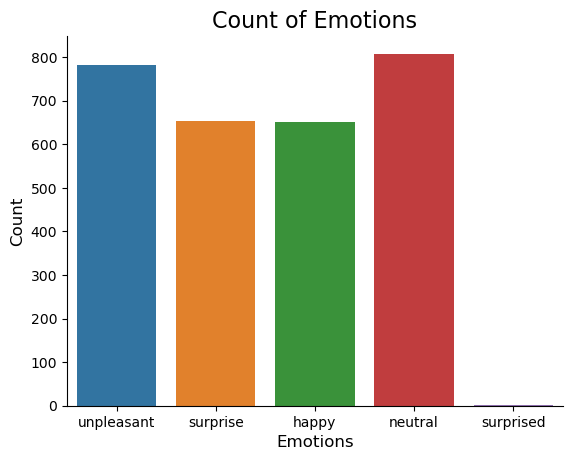

In [7]:
plt.title('Count of Emotions', size=16)
sns.countplot(data=aggregated_data, x='Emotions')  # Specify x as 'Emotions'
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


In [8]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

In [9]:
def noise(data):
    noise_amp = 0.5*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [10]:
def create_waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for {} emotion'.format(emotion), size=15)
    time = np.arange(0, len(data)) / sr
    plt.plot(time, data)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

# Rest of your code remains unchanged


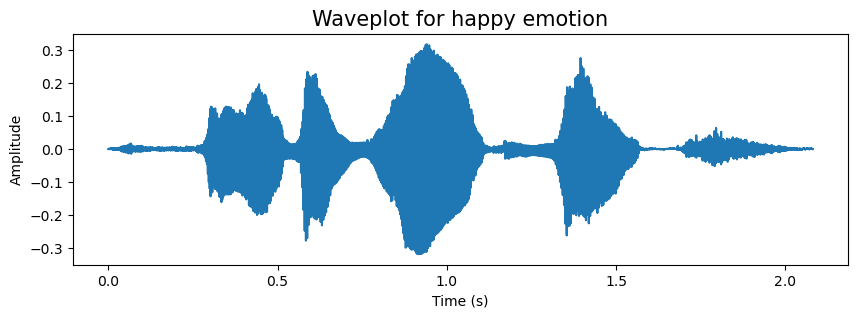

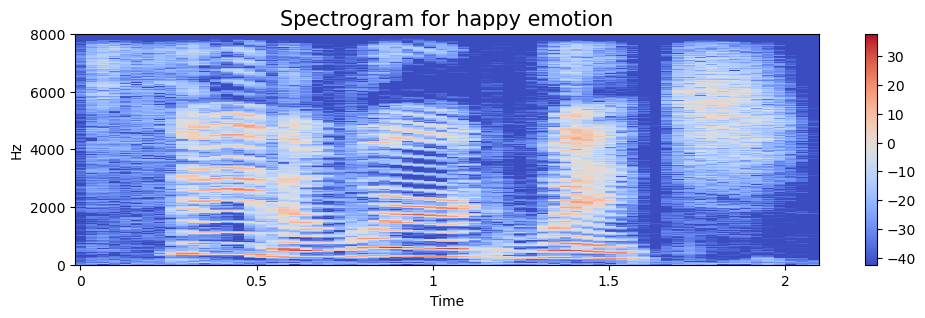

In [11]:
emotion='happy'
path = np.array(aggregated_data.Path[aggregated_data.Emotions==emotion])[1]
data, sample_rate = librosa.load(path, sr=None)  # Set sr=None to get the native sample rate
resampled_data = librosa.resample(data, orig_sr=sample_rate, target_sr=16000)
noised_data = noise(resampled_data)

create_waveplot(resampled_data, 16000, emotion)
create_spectrogram(resampled_data, 16000, emotion)
Audio(data=noised_data, rate=16000)


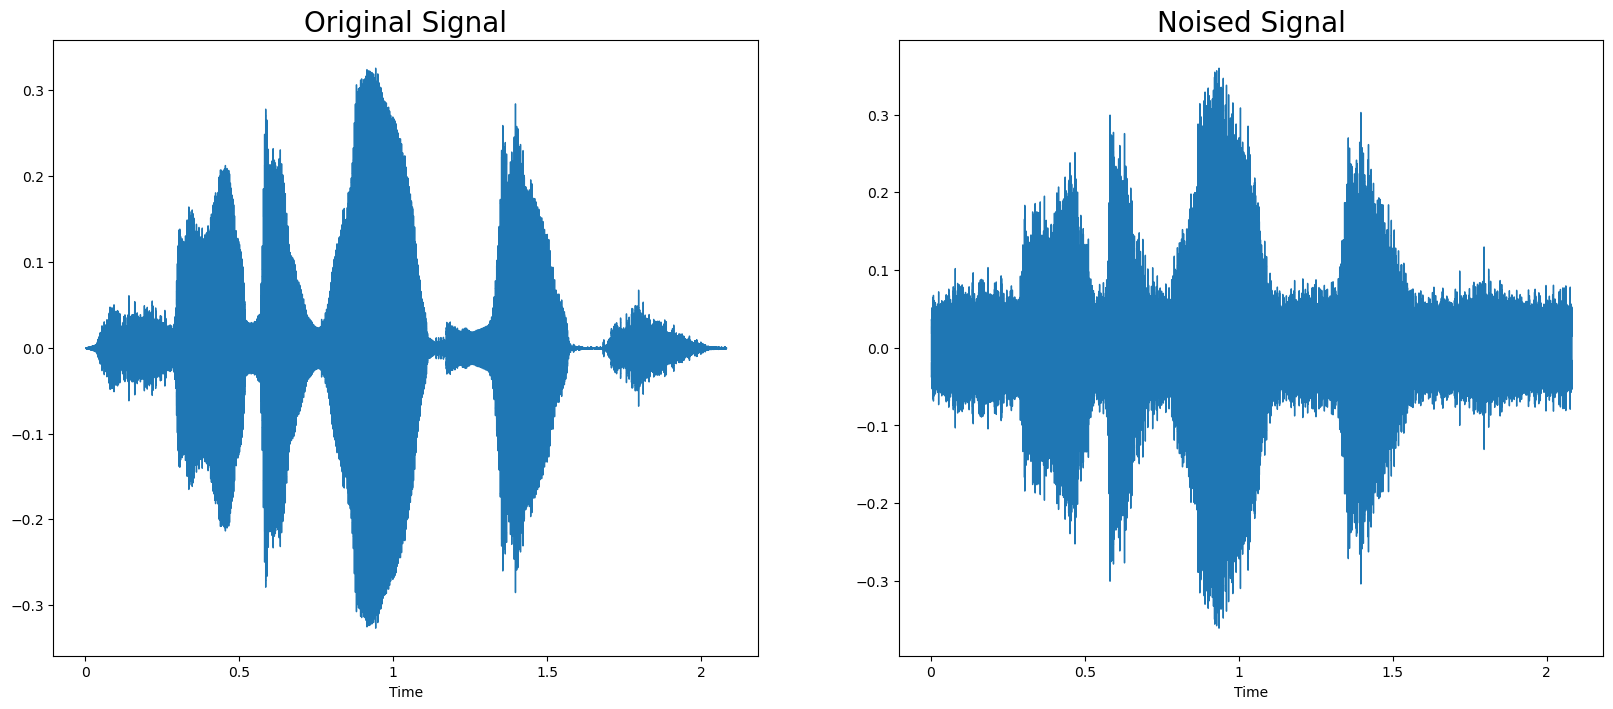

In [12]:
import matplotlib.pyplot as plt
import librosa.display

fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplots_adjust(hspace=0.4)

axs[0].set_title('Original Signal', size=20)
librosa.display.waveshow(y=data, sr=sample_rate, ax=axs[0])

axs[1].set_title('Noised Signal', size=20)
noise_data = noise(data)
librosa.display.waveshow(y=noise_data, sr=sample_rate, ax=axs[1])

plt.show()


In [13]:
labels = {'neutral':0, 'happy':1, 'surprise':2, 'unpleasant': 3}
aggregated_data.replace({'Emotions':labels},inplace=True)
aggregated_data.head()

,Emotions,Path
2,3,/Users/mananhingorani/Speech-Emotion-Recogniti...
4,2,/Users/mananhingorani/Speech-Emotion-Recogniti...
6,1,/Users/mananhingorani/Speech-Emotion-Recogniti...
7,0,/Users/mananhingorani/Speech-Emotion-Recogniti...
12,2,/Users/mananhingorani/Speech-Emotion-Recogniti...


In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
# Constants
NUM_MFCC = 13
N_FFT = 2048
HOP_LENGTH = 512
SAMPLE_RATE = 22050
DOWN_SAMPLE_RATE = 16000
SAMPLE_NUM = aggregated_data.shape[0]

data = {
    "labels": [],
    "features": []
}

MAX_SEQUENCE_LENGTH = 100 

def extract_features(signal, sample_rate):
    # Compute the spectrogram
    spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_fft=N_FFT, hop_length=HOP_LENGTH)

    # Extract MFCC features from the spectrogram
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(spectrogram), n_mfcc=NUM_MFCC)

    # Transpose the feature matrix
    feature = mfcc.T

    return feature

for i in range(SAMPLE_NUM):
    # Inside your loop
    file_path = aggregated_data.iloc[i, 1]

    if os.path.isfile(file_path):
        signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

        # Cropping & Resampling
        start_time = 0.4
        end_time = 1.9
        start_frame = int(start_time * sample_rate)
        end_frame = int(end_time * sample_rate)
        signal = signal[start_frame:end_frame]

        # Resample
        signal = librosa.resample(signal, orig_sr=sample_rate, target_sr=DOWN_SAMPLE_RATE)

        # Add noise
        signal_noised = noise(signal)

        # Extract features for original signal
        features_original = extract_features(signal, DOWN_SAMPLE_RATE)
        data["labels"].append(aggregated_data.iloc[i, 0])
        data["features"].append(features_original)

        # Extract features for noised signal
        features_noised = extract_features(signal_noised, DOWN_SAMPLE_RATE)
        data["labels"].append(aggregated_data.iloc[i, 0])
        data["features"].append(features_noised)

        if i % 100 == 0:
            print(f'Processing Data: {i}/{SAMPLE_NUM}')
    else:
        print(f'Skipping directory: {file_path}')

# Convert lists to numpy arrays
data["features"] = pad_sequences(data["features"], maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post', dtype='float32')
data["labels"] = np.array(data["labels"])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data["features"], data["labels"], test_size=0.2, random_state=42)


Processing Data: 0/2896
Processing Data: 100/2896
Processing Data: 200/2896
Processing Data: 300/2896
Processing Data: 400/2896
Processing Data: 500/2896
Processing Data: 600/2896
Processing Data: 700/2896
Processing Data: 800/2896
Processing Data: 900/2896
Processing Data: 1000/2896
Processing Data: 1100/2896
Processing Data: 1200/2896
Processing Data: 1300/2896
Processing Data: 1400/2896
Skipping directory: /Users/mananhingorani/Speech-Emotion-Recognition-TinyML/TESS/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_pleasant_surprised
Processing Data: 1500/2896
Processing Data: 1600/2896
Processing Data: 1700/2896
Processing Data: 1800/2896
Skipping directory: /Users/mananhingorani/Speech-Emotion-Recognition-TinyML/TESS/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Pleasant_surprise
Processing Data: 1900/2896
Processing Data: 2000/2896
Processing Data: 2100/2896
Processing Data: 2200/2896
Processing Data: 2300/2896
P

In [16]:
data["features"] = [feature.flatten() for feature in data["features"]]

# Create a DataFrame
Features = pd.DataFrame(data)

# Save the DataFrame to a CSV file
Features.to_csv('Features.csv', index=False)

# Display the first few rows of the DataFrame
Features.head()

,labels,features
0,3,"[-125.51096, 14.325594, -21.261644, 37.74021, ..."
1,3,"[18.344687, -0.91877115, -5.4461117, 5.8338895..."
2,2,"[-238.82256, 126.67488, -12.833922, -0.9531178..."
3,2,"[-46.63913, 6.791392, 6.115416, -0.26310295, -..."
4,1,"[-794.08167, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


In [17]:
X = np.asarray(Features['features'])
y = np.asarray(Features["labels"])

# Pad Features to make them of equal length
X = tf.keras.preprocessing.sequence.pad_sequences(X)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

print(f'Training Data:{X_train.shape} with label {y_train.shape}')
print(f'Validate Data:{X_validation.shape} with label {y_validation.shape}')
print(f' Testing Data:{X_test.shape} with label {y_test.shape}')

Training Data:(4167, 1300) with label (4167,)
Validate Data:(1042, 1300) with label (1042,)
 Testing Data:(579, 1300) with label (579,)


In [19]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [20]:
def build_model(input_shape):
    model = tf.keras.Sequential()

    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(64))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(4, activation='softmax'))

    return model

# Adjusted for sequences of length 100
input_shape = (MAX_SEQUENCE_LENGTH, NUM_MFCC)
model = build_model(input_shape)

# Compile model
optimiser = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 128)          72704     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 126532 (494.27 KB)
Trainable params: 126532 (494.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
X_train = X_train.reshape((X_train.shape[0], MAX_SEQUENCE_LENGTH, NUM_MFCC))
X_validation = X_validation.reshape((X_validation.shape[0], MAX_SEQUENCE_LENGTH, NUM_MFCC))
X_test = X_test.reshape((X_test.shape[0], MAX_SEQUENCE_LENGTH, NUM_MFCC))


In [22]:
EPOCHS = 20
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=EPOCHS)

Epoch 1/20
131/131 [==============================] - 11s 75ms/step - loss: 1.2113 - accuracy: 0.4099 - val_loss: 1.1314 - val_accuracy: 0.4357
Epoch 2/20
131/131 [==============================] - 10s 74ms/step - loss: 1.0880 - accuracy: 0.4922 - val_loss: 1.1491 - val_accuracy: 0.4443
Epoch 3/20
131/131 [==============================] - 10s 78ms/step - loss: 1.0966 - accuracy: 0.4725 - val_loss: 1.0038 - val_accuracy: 0.4971
Epoch 4/20
131/131 [==============================] - 10s 74ms/step - loss: 0.9844 - accuracy: 0.5224 - val_loss: 0.9986 - val_accuracy: 0.4837
Epoch 5/20
131/131 [==============================] - 10s 74ms/step - loss: 0.9476 - accuracy: 0.5532 - val_loss: 0.9274 - val_accuracy: 0.5825
Epoch 6/20
131/131 [==============================] - 10s 74ms/step - loss: 0.9398 - accuracy: 0.5870 - val_loss: 0.8777 - val_accuracy: 0.6027
Epoch 7/20
131/131 [==============================] - 10s 73ms/step - loss: 0.8808 - accuracy: 0.6091 - val_loss: 0.8522 - val_accuracy:

In [23]:
# Create a new directory called 'Models' to store the model
output_dir = 'Models'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the model in the 'Models' directory
model.save('Models/Speech-Emotion-Recognition-Model-new.h5')
print('Save the Tensorflow model!')


Save the Tensorflow model!


In [24]:
import pickle

# Define paths
model_weights_path = 'Models/Speech-Emotion-Recognition-Model-new_weights.pkl'
model_architecture_path = 'Models/Speech-Emotion-Recognition-Model-new_architecture.pkl'

# Save model weights
with open(model_weights_path, 'wb') as f:
    pickle.dump(model.get_weights(), f)

# Save model architecture
with open(model_architecture_path, 'wb') as f:
    pickle.dump(model.to_json(), f)


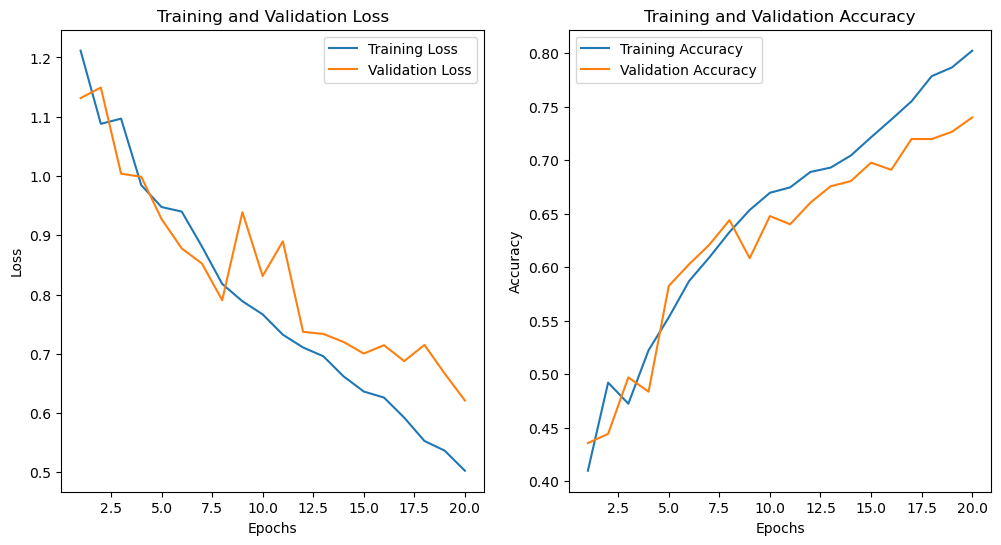

In [25]:
import matplotlib.pyplot as plt

# Access the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS+1), train_loss, label='Training Loss')
plt.plot(range(1, EPOCHS+1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS+1), train_acc, label='Training Accuracy')
plt.plot(range(1, EPOCHS+1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [26]:
# Load model architecture
with open(model_architecture_path, 'rb') as f:
    architecture = pickle.load(f)

# Load model weights
with open(model_weights_path, 'rb') as f:
    weights = pickle.load(f)

# Reconstruct model
from tensorflow.keras.models import model_from_json

reconstructed_model = model_from_json(architecture)
reconstructed_model.set_weights(weights)


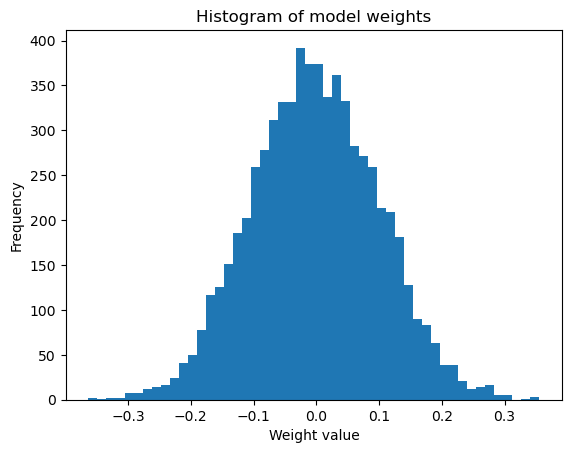

In [27]:
weights = reconstructed_model.get_weights()

# Plot a histogram of the weights
plt.hist(weights[0].flatten(), bins=50)
plt.xlabel('Weight value')
plt.ylabel('Frequency')
plt.title('Histogram of model weights')
plt.show()

In [28]:
# Convert to TensorFlow Lite model with TF kernels fallback
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with tf.io.gfile.GFile("Models/SER.tflite", 'wb') as f:
    f.write(tflite_model)

# Apply optimizations and convert to quantized TensorFlow Lite model
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quant_tflite_model = converter.convert()

# Save the quantized TensorFlow Lite model
with tf.io.gfile.GFile("Models/SER_quant.tflite", 'wb') as f:
    f.write(quant_tflite_model)

print("Save the TensorFlow 'Lite' model!")

INFO:tensorflow:Assets written to: /var/folders/22/yhwhv5gd6f3bfwm46s4bztfw0000gn/T/tmpzrio87xl/assets


INFO:tensorflow:Assets written to: /var/folders/22/yhwhv5gd6f3bfwm46s4bztfw0000gn/T/tmpzrio87xl/assets
2024-04-08 14:39:48.671440: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-04-08 14:39:48.671472: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-04-08 14:39:48.672266: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/22/yhwhv5gd6f3bfwm46s4bztfw0000gn/T/tmpzrio87xl
2024-04-08 14:39:48.678350: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-04-08 14:39:48.678363: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/22/yhwhv5gd6f3bfwm46s4bztfw0000gn/T/tmpzrio87xl
2024-04-08 14:39:48.698549: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-04-08 14:39:48.708068: I tensorflow/cc/saved_model/load

INFO:tensorflow:Assets written to: /var/folders/22/yhwhv5gd6f3bfwm46s4bztfw0000gn/T/tmpfghqlt_i/assets


INFO:tensorflow:Assets written to: /var/folders/22/yhwhv5gd6f3bfwm46s4bztfw0000gn/T/tmpfghqlt_i/assets


Save the TensorFlow 'Lite' model!


2024-04-08 14:39:51.775973: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-04-08 14:39:51.775990: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-04-08 14:39:51.776121: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/22/yhwhv5gd6f3bfwm46s4bztfw0000gn/T/tmpfghqlt_i
2024-04-08 14:39:51.782194: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-04-08 14:39:51.782202: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/22/yhwhv5gd6f3bfwm46s4bztfw0000gn/T/tmpfghqlt_i
2024-04-08 14:39:51.805405: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-04-08 14:39:51.862441: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /var/folders/22/yhwhv5gd6f3bfwm46s4bztfw0000gn/T/tmpfghqlt_i
2024-04-

In [29]:
print("Model Sizes:")
!ls -lh Models | awk '{print $5 "\t" $9}'

Model Sizes:
	
514K	SER.tflite
904K	SER_micro.cc
147K	SER_quant.tflite
1.5M	Speech-Emotion-Recognition-Model-new.h5
4.0K	Speech-Emotion-Recognition-Model-new_architecture.pkl
495K	Speech-Emotion-Recognition-Model-new_weights.pkl
1.5M	Speech-Emotion-Recognition-Model.h5


In [30]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import librosa
import numpy as np

# Load the saved model
saved_model_path = '/Users/mananhingorani/Speech-Emotion-Recognition-TinyML/Models/Speech-Emotion-Recognition-Model-new.h5'
loaded_model = load_model(saved_model_path)

In [31]:
# Function to extract features from sound data
def extract_features(file_path, max_sequence_length=100):
    # Load sound file using librosa
    signal, sample_rate = librosa.load(file_path, sr=None)

    # Cropping & Resampling (similar to what you did during training)
    start_time = 0.4
    end_time = 1.9
    start_frame = int(start_time * sample_rate)
    end_frame = int(end_time * sample_rate)
    signal = signal[start_frame:end_frame]

    # Resample
    signal = librosa.resample(signal, orig_sr=sample_rate, target_sr=16000)

    # Extract features for the sound data
    spectrogram = librosa.feature.melspectrogram(y=signal, sr=16000, n_fft=2048, hop_length=512)
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(spectrogram), n_mfcc=13)

    # Transpose features to have shape (num_features, sequence_length)
    features = mfcc.T

    # Pad or truncate features to a fixed length
    features = np.pad(features, ((0, max_sequence_length - features.shape[0]), (0, 0)), mode='constant')

    return features


In [32]:
def predict_emotion(sound_file_path):
    # Extract features
    sound_features = extract_features(sound_file_path)

    # Ensure sound_features has the correct shape (adjust if necessary)
    sound_features = np.expand_dims(sound_features, axis=0)

    # Make predictions using the loaded model
    emotion_probabilities = loaded_model.predict(sound_features)

    # Convert the probabilities to emotion labels
    predicted_emotion = np.argmax(emotion_probabilities, axis=1)

    # Map the predicted label to the actual emotion class (e.g., using a dictionary)
    emotion_mapping = {0: 'neutral', 1: 'happy', 2: 'surprise', 3: 'unpleasant'}
    predicted_emotion_label = emotion_mapping[predicted_emotion[0]]

    return predicted_emotion_label

In [33]:
sound_file_path = '/Users/mananhingorani/Downloads/Business Badhao 4.m4a'
predicted_emotion = predict_emotion(sound_file_path)

# Print or use the predicted emotion label
print("Predicted Emotion:", predicted_emotion)

1/1 [==============================] - 0s 356ms/step
Predicted Emotion: unpleasant


In [34]:
sound_file_path = '/Users/mananhingorani/Downloads/Business Badhao 5.m4a'
predicted_emotion = predict_emotion(sound_file_path)

# Print or use the predicted emotion label
print("Predicted Emotion:", predicted_emotion)

1/1 [==============================] - 0s 30ms/step
Predicted Emotion: surprise


In [35]:
sound_file_path = '/Users/mananhingorani/Downloads/Business Badhao 9.m4a'
predicted_emotion = predict_emotion(sound_file_path)

# Print or use the predicted emotion label
print("Predicted Emotion:", predicted_emotion)

1/1 [==============================] - 0s 38ms/step
Predicted Emotion: unpleasant
